# Wind Quadrant Tests

In [1]:
%matplotlib inline
from utils import *
import io_utils as io
import vis_utils as vis
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from scipy.stats import beta, expon, truncnorm, norm, uniform
from scipy.sparse.linalg import lsqr
from scipy.optimize import minimize
from time import process_time
from functools import reduce
from pandas import ExcelWriter
from pandas import ExcelFile
import xlrd
import re
pd.options.display.float_format = '{:,g}'.format
plt.style.use(['ggplot'])

In [2]:
filename = "./data/colima/colima_real_data.csv"

raw_df, grid = io.import_colima(filename)

grid.to_csv("data/colima/colima_grid.csv", sep=" ", header=False, index=False)

display(raw_df)

,Sample no.,Easting,Northing,MassArea,Thickness,"[-5,-4)","[-4,-3)","[-3,-2)","[-2,-1)","[-1,0)","[0,1)","[1,2)","[2,3)","[3,4)",radius
16,VF0004a,1499,1506,625.8,60,19.2,31,18,11,6,2,1,0.6,0.9,"2,124.86"
18,VF0006a3,1957,1997,417.2,40,6.7,30,25,17,11,5,1,0.8,0.8,"2,796.04"
17,VF0005a3,1787,2173,500.64,48,10.1,30,24,16,9,3,1,0.7,1,"2,813.41"
37,VF0603509,-770,3082,594.51,57,11.3,25,25,19,11,4,1,0.6,0.5,"3,176.73"
31,VF0508a3,-1673,3152,125.16,12,10,22,24,16,10,4,2,0.8,0.8,"3,568.48"
36,VF0518a3,-637,4876,166.88,16,3.1,21,25,22,16,7,2,0.9,0.8,"4,917.43"
35,VF0517a,-1268,5048,125.16,12,9.8,14,17,20,17,10,4,2.1,1.8,"5,204.82"
34,VF0516a3,-2101,5517,93.87,9,4.1,15,19,19,19,12,4,2.6,2.8,"5,903.52"
33,VF0514a3,-2250,5771,62.58,6,0.1,9,13,19,21,14,7,4.6,5.6,"6,194.11"
32,VF0513a,-2272,5925,62.58,6,4.2,9,17,19,17,11,8,5.5,4.2,"6,345.68"


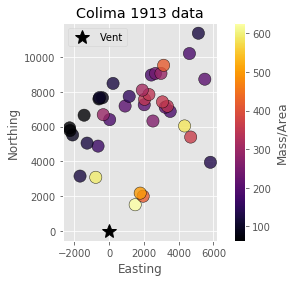

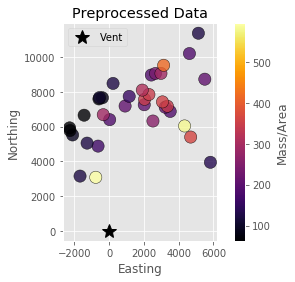

In [3]:
vis.plot_sample(raw_df, vent=(0,0), log=False, title="Colima 1913 data", cbar_label="Mass/Area")
plt.show()
# plt.savefig("colima/all_points.png", dpi=200, format='png')

obs_df = raw_df.copy()

obs_df = obs_df.drop([16, 18, 17])
#This is going to be 100 across. Just needs to be the same as the other dfs. 
obs_df["Residual"] = obs_df["MassArea"]/obs_df["MassArea"]*100

vis.plot_sample(obs_df, vent=(0,0), log=False, title="Preprocessed Data", cbar_label="Mass/Area")
# plt.savefig("colima/All_trans.png", dpi=200, format='png')
plt.show()

In [4]:
# grid.to_csv("data/colima/colima_grid.csv", sep=" ", header=False, index=False)

# t2_df, _, _, _ = io.read_tephra2("data/colima/colima_tephra2_sim_data.txt")

# t2_df["Residual"] = t2_df["MassArea"].values/obs_df["MassArea"].values

# display(t2_df.head())

In [5]:
# t2_const_df, _, _, _ = io.read_tephra2("data/colima/colima_tephra2_const_wind_sim_data.txt")

# t2_const_df["Residual"] = t2_const_df["MassArea"]/obs_df["MassArea"]

# display(t2_const_df.head())

In [6]:
config = io.read_tephra2_config("data/colima/colima_config.txt")

globs = {
    "LITHIC_DIAMETER_THRESHOLD": 7.,
    "PUMICE_DIAMETER_THRESHOLD": -1.,
    "AIR_VISCOSITY": 0.000018325,
    "AIR_DENSITY":  1.293,
    "GRAVITY": 9.81,
}

# Update parameters
config["COL_STEPS"] = 20
config["PART_STEPS"] = 9

config["MAX_GRAINSIZE"] = -5
config["MIN_GRAINSIZE"] = 4

# Additional parameter: Constant wind speed
config["WIND_SPEED"] = 10

print("INPUT PARAMETERS:")
display(config)
display(globs)

INPUT PARAMETERS:


{'VENT_EASTING': 0.0,
 'VENT_NORTHING': 0.0,
 'VENT_ELEVATION': 3085.0,
 'PLUME_HEIGHT': 24000.0,
 'ALPHA': 1.02,
 'BETA': 1.56,
 'ERUPTION_MASS': 55000000000.0,
 'MAX_GRAINSIZE': -5,
 'MIN_GRAINSIZE': 4,
 'MEDIAN_GRAINSIZE': -1.8,
 'STD_GRAINSIZE': 2.4,
 'EDDY_CONST': 0.04,
 'DIFFUSION_COEFFICIENT': 4016.0,
 'FALL_TIME_THRESHOLD': 6458.0,
 'LITHIC_DENSITY': 2700.0,
 'PUMICE_DENSITY': 1024.0,
 'COL_STEPS': 20,
 'PART_STEPS': 9,
 'PLUME_MODEL': 2.0,
 'WIND_SPEED': 10}

{'LITHIC_DIAMETER_THRESHOLD': 7.0,
 'PUMICE_DIAMETER_THRESHOLD': -1.0,
 'AIR_VISCOSITY': 1.8325e-05,
 'AIR_DENSITY': 1.293,
 'GRAVITY': 9.81}

,centroid,density,interval,lower,probability,upper
0,-4.5,"1,024","[-5,-4)",-5,0.0683375,-4
1,-3.5,"1,024","[-4,-3)",-4,0.109203,-3
2,-2.5,"1,024","[-3,-2)",-3,0.146694,-2
3,-1.5,"1,024","[-2,-1)",-2,0.16565,-1
4,-0.5,"1,024","[-1,0)",-1,0.157243,0
5,0.5,"1,233.5","[0,1)",0,0.125474,1
6,1.5,"1,443","[1,2)",1,0.0841661,2
7,2.5,"1,652.5","[2,3)",2,0.0474595,3
8,3.5,"1,862","[3,4)",3,0.0224962,4


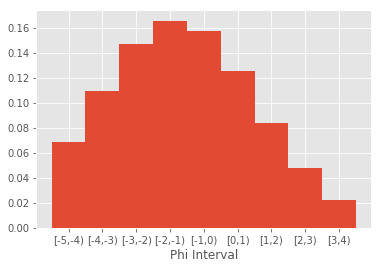

In [7]:
phi_steps = get_phi_steps(config["MIN_GRAINSIZE"], config["MAX_GRAINSIZE"], 
                          config["PART_STEPS"], 
                          config["MEDIAN_GRAINSIZE"], config["STD_GRAINSIZE"],
                          globs["LITHIC_DIAMETER_THRESHOLD"], 
                          globs["PUMICE_DIAMETER_THRESHOLD"], 
                          config["LITHIC_DENSITY"], config["PUMICE_DENSITY"])
step_width = (config["MAX_GRAINSIZE"] - config["MIN_GRAINSIZE"])/config["PART_STEPS"]

display(pd.DataFrame(phi_steps))



probs = [phi["probability"] for phi in phi_steps]
x = [phi["centroid"] for phi in phi_steps]
labels = [phi["interval"] for phi in phi_steps]
fig, ax = plt.subplots(facecolor='w', edgecolor='k')
ax.bar(x, probs, width=1, align="center")
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.xlabel("Phi Interval")
plt.show()

[7.964348000000002, 30.771479999999993, 43.53482, 47.97502, 48.19852, 31.024780000000003, 7.1043199999999995, 1.534998, 1.428612]
[-4.5, -3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5]


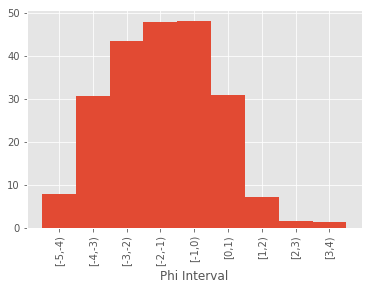

In [8]:
tgsd = []

for phi in phi_steps:
    tgsd += [sum((obs_df[phi["interval"]]/100)*obs_df["MassArea"])/len(obs_df)]
print(tgsd)
print(x)
fig, ax = plt.subplots(facecolor='w', edgecolor='k')
ax.bar(x, tgsd, width=1, align="center")
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
plt.xlabel("Phi Interval")
plt.show()

In [9]:
t = process_time()
t_tot = process_time()
df_list = []

q_dist = beta(config["ALPHA"],config["BETA"])

grid = obs_df[["Easting", "Northing"]]
wind_angle = np.radians(55)

u = config["WIND_SPEED"]*np.cos(wind_angle)
v = config["WIND_SPEED"]*np.sin(wind_angle)
for phi_step in phi_steps:
    mass_in_phi = config["ERUPTION_MASS"] * phi_step["probability"]
    input_table, gsm_df, sig, vv, tft= gaussian_stack_single_phi(
        grid, 20, config["VENT_ELEVATION"], 
        config["PLUME_HEIGHT"], 
        (config["ALPHA"], config["BETA"]),
        mass_in_phi, (u,v), 
        phi_step["lower"], phi_step["density"], 2500,
        config["DIFFUSION_COEFFICIENT"],
        config["EDDY_CONST"],
        config["FALL_TIME_THRESHOLD"])
    df_list.append(gsm_df.rename(columns={"MassArea":phi_step["interval"]}))


elapsed_time = process_time() - t
print("Forward Sim time: %.5f seconds"%elapsed_time)

t = process_time()
df_merge = reduce(lambda x, y: pd.merge(x, y, on =['Northing', 'Easting']), df_list)
elapsed_time = process_time() - t
print("Dataframe Merge time: %.5f seconds"%elapsed_time)

t = process_time()
df_merge["MassArea"] = np.sum(df_merge[labels], 1)
elapsed_time = process_time() - t
print("Tot M/A calc time: %.5f seconds"%elapsed_time)

t = process_time()
for label in labels:
    df_merge[label] = df_merge.apply(lambda row: (row[label]/row["MassArea"])*100, axis=1) # This operation is much faster

elapsed_time = process_time() - t
print("Phi Wt perc calc time: %.5f seconds"%elapsed_time)

total_time = process_time() - t_tot
print("Total time: %.5f seconds"%total_time)

forward_df = df_merge

# forward_df["MassArea"] = forward_df["MassArea"]*(6991/9469)

forward_df["radius"] = np.sqrt(forward_df["Easting"]**2 + forward_df["Northing"]**2)
forward_df = forward_df.sort_values(by=['radius'])
forward_df["Residual"] = forward_df["MassArea"].values/obs_df["MassArea"].values
display(forward_df.head())

print(u, v)

Forward Sim time: 0.03125 seconds
Dataframe Merge time: 0.01562 seconds
Tot M/A calc time: 0.00000 seconds
Phi Wt perc calc time: 0.00000 seconds
Total time: 0.04688 seconds


,Northing,Easting,"[-5,-4)","[-4,-3)","[-3,-2)","[-2,-1)","[-1,0)","[0,1)","[1,2)","[2,3)","[3,4)",MassArea,radius,Residual
0,3082,-770,14.7853,22.8202,24.5354,19.4649,12.2911,5.1388,0.923165,0.0411244,9.10413e-05,333.415,"3,176.73",0.560822
1,3152,-1673,15.3395,23.3135,24.4879,18.835,11.7161,5.17305,1.08024,0.0545369,0.00013203,124.542,"3,568.48",0.99506
2,4876,-637,7.91177,18.121,25.9636,23.6013,15.1298,6.91236,2.17863,0.180861,0.000616265,184.412,"4,917.43",1.10506
3,5048,-1268,7.78623,18.12,26.2072,23.7255,14.9543,6.72752,2.26616,0.212341,0.000792074,101.011,"5,204.82",0.807058
4,5517,-2101,6.5856,16.9983,26.6262,24.9291,15.3941,6.66536,2.48568,0.314196,0.00148972,37.3728,"5,903.52",0.398134


5.7357643635104605 8.191520442889917


In [10]:
forward_df["phi_total"] = forward_df[labels].sum()

display(forward_df[labels].sum(axis=1))

0    100
1    100
2    100
3    100
4    100
5    100
6    100
7    100
8    100
9    100
10   100
11   100
12   100
13   100
14   100
15   100
16   100
17   100
18   100
19   100
20   100
21   100
22   100
23   100
24   100
25   100
26   100
27   100
28   100
29   100
30   100
31   100
32   100
33   100
34   100
dtype: float64

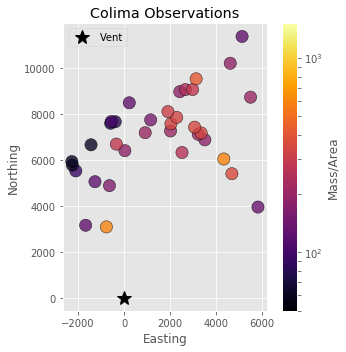

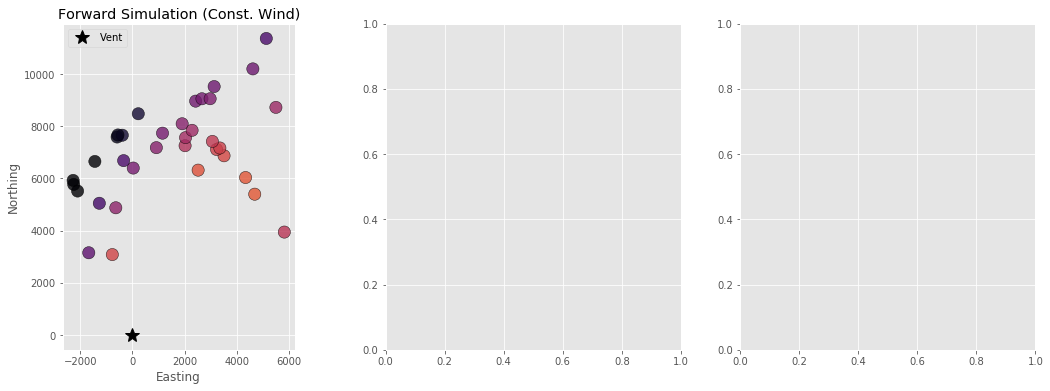

In [11]:

fig, ax = plt.subplots(1, 1, figsize=(5,5))

vis.plot_sample(obs_df, vent=(0,0), log=True, bounds=(50, 1500),
            title="Colima Observations", cbar_label="Mass/Area", ax = ax)
plt.tight_layout()
plt.show()


fig, axs = plt.subplots(1, 3, figsize=(
        18,6), facecolor='w', edgecolor='k')
axs = axs.ravel()

vis.plot_sample(forward_df, vent=(0,0), log=True, bounds=(50, 1500), show_cbar=False,
            title="Forward Simulation (Const. Wind)", cbar_label="Mass/Area", ax=axs[0])
# vis.plot_sample(t2_const_df, vent=(0,0), log=True, bounds=(50, 1500), show_cbar=False,
#             title="Tephra2 Simulation (Const. Wind)", cbar_label="Mass/Area", ax=axs[1])
# vis.plot_sample(t2_df, vent=(0,0), log=True, bounds=(50, 1500),
#             title="Tephra2 Simulation (NOAA Wind)", cbar_label="Mass/Area", ax=axs[2])
plt.show()




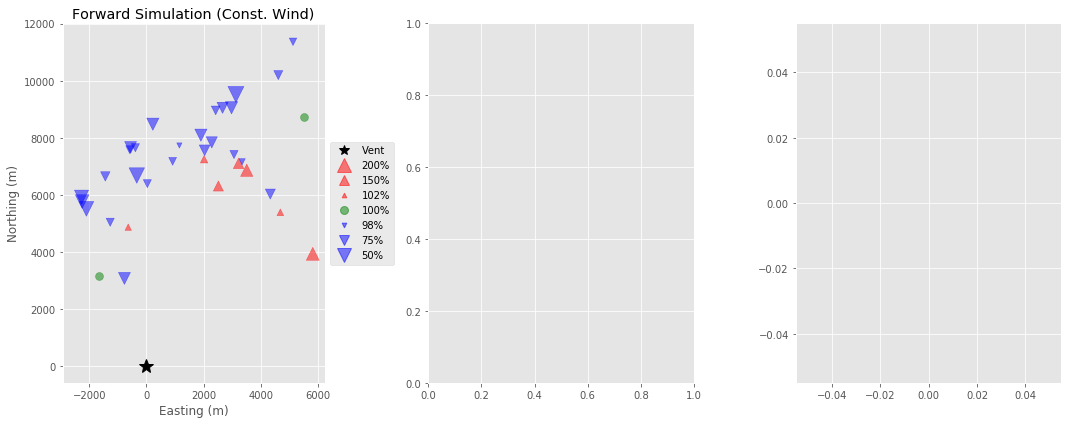

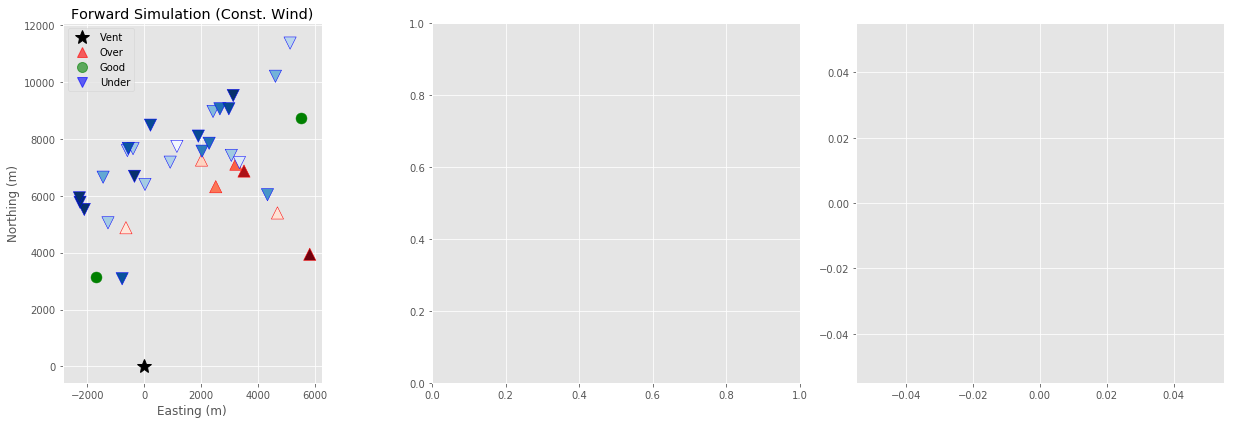

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(
        15,6), facecolor='w', edgecolor='k')
axs = axs.ravel()


vis.plot_residuals(forward_df, vent=(0,0), values="Residual",
            title="Forward Simulation (Const. Wind)", 
            plot_type = "size", ax=axs[0])
# vis.plot_residuals(t2_const_df, vent=(0,0), values="Residual",
#             title="Tephra2 Simulation (Const. Wind)", 
#              plot_type = "size", ax=axs[1])
# vis.plot_residuals(t2_df, vent=(0,0), values="Residual",
#             title="Tephra2 Simulation (NOAA Wind)", 
#              plot_type = "size", ax=axs[2])


plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 3, figsize=(
        18,6), facecolor='w', edgecolor='k')
axs = axs.ravel()


vis.plot_residuals(forward_df, vent=(0,0), values="Residual",
            title="Forward Simulation (Const. Wind)", 
            plot_type = "cmap", ax=axs[0], show_cbar = False)
# vis.plot_residuals(t2_const_df, vent=(0,0), values="Residual",
#             title="Tephra2 Simulation (Const. Wind)", 
#              plot_type = "cmap", ax=axs[1], show_cbar = False)
# vis.plot_residuals(t2_df, vent=(0,0), values="Residual",
#             title="Tephra2 Simulation (NOAA Wind)", 
#              plot_type = "cmap", ax=axs[2], show_cbar = True)


# plt.tight_layout()
plt.show()

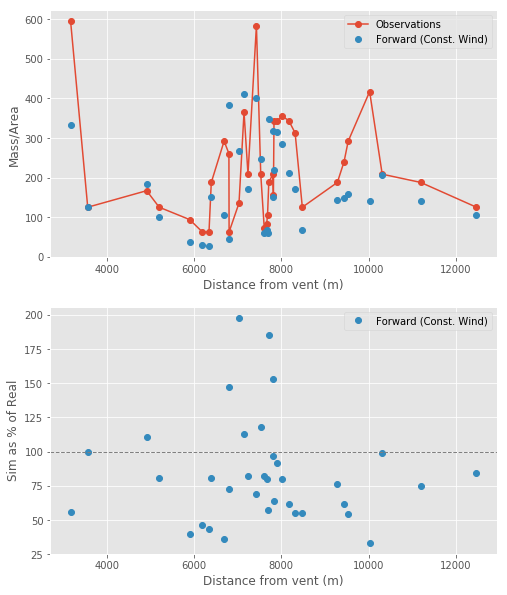

In [13]:
fig, axs = plt.subplots(2,1, figsize=(
        8,10), facecolor='w', edgecolor='k')
axs = axs.ravel()

axs[0].plot(obs_df["radius"].values, obs_df["MassArea"].values, 'C0o-', label="Observations")
# plt.plot(rotdf["radius"].values, rotdf["MassArea"].values, 'C1o-')
axs[0].plot(forward_df["radius"].values, forward_df["MassArea"].values, 'C1o', label="Forward (Const. Wind)")
# axs[0].plot(t2_const_df["radius"].values, t2_const_df["MassArea"].values, 'C2o', label="Tephra2 (Const. Wind)")
# axs[0].plot(t2_df["radius"].values, t2_df["MassArea"].values, 'C3o', label="Tephra2 (NOAA Wind)")
axs[0].legend()
axs[0].set_xlabel("Distance from vent (m)")
axs[0].set_ylabel("Mass/Area")

axs[1].plot(forward_df["radius"].values, forward_df["Residual"].values*100, 'C1o', label="Forward (Const. Wind)")
# axs[1].plot(t2_const_df["radius"].values, t2_const_df["Residual"].values*100, 'C2o', label="Tephra2 (Const. Wind)")
# axs[1].plot(t2_df["radius"].values, t2_df["Residual"].values*100, 'C3o', label="Tephra2 (NOAA Wind)")
axs[1].axhline(100, linestyle="--", lw=1, c="gray")
axs[1].legend()
axs[1].set_xlabel("Distance from vent (m)")
axs[1].set_ylabel("Sim as % of Real")
plt.show()

In [14]:
q1_trans = (1,1)
q2_trans = (-1,1)
q3_trans = (-1,-1)
q4_trans = (1,-1)

trans_tests = [
    q1_trans,
    q2_trans,
    q3_trans,
    q4_trans
]

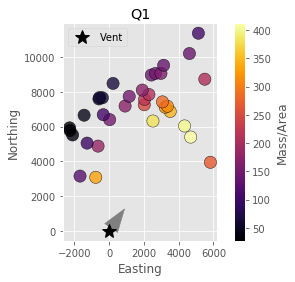

========Q1========
(1, 1)
{'a': 2, 'b': 5, 'h1': 24000.0, 'u': 5.7357643635104605, 'v': 8.191520442889917, 'D': 4016.0, 'ftt': 6458.0, 'M': 55000000000.0}


C:\Users\nmostert\Documents\repos\inversion_project\utils.py:476: RuntimeWarning: divide by zero encountered in double_scalars
  factor_a = (1/((a-1)*(b-1)*(H-h1)))


a* = -3.04662	b* = -0.11643	            h1* = 134.67548	u* = 5.21641	v* = 7.49243	            D* = 8.15897	ftt* = 8.77307	TM* = 24.73060
a = 1.04752	b = 1.89009	            h1 = 30000.00000	u = 5.21641	v = 7.49243	            D = 3494.57207	ftt = 6458.00000	TM = 55000000000.00002
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 776
SSE: 7.762670604200848


,Height,Suspended Mass
0,"4,430.75",4.80439e+09
1,"5,776.5",4.73198e+09
2,"7,122.25",4.58475e+09
3,"8,468",4.40369e+09
4,"9,813.75",4.20217e+09
5,"11,159.5",3.98627e+09
6,"12,505.2",3.75924e+09
7,"13,851",3.52302e+09
8,"15,196.8",3.27876e+09
9,"16,542.5",3.0272e+09


[]


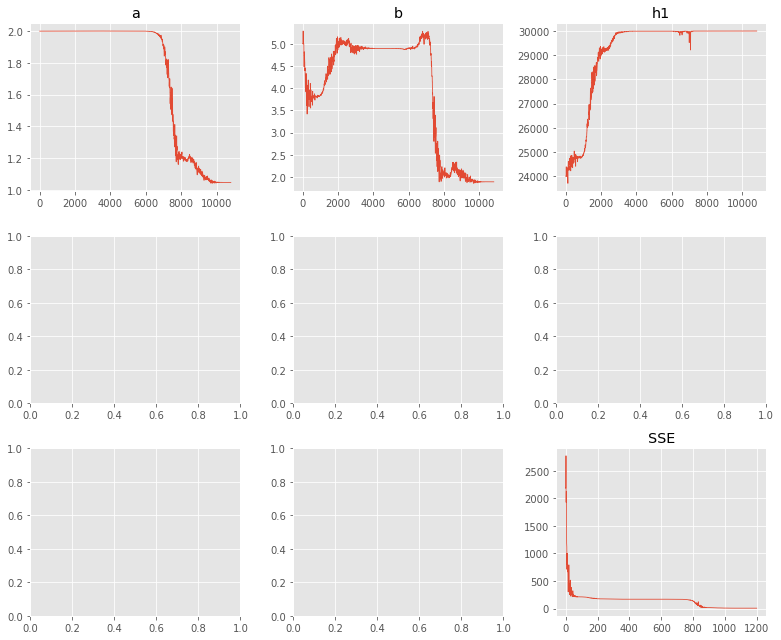

Q1 Run Time: 1.73776 minutes




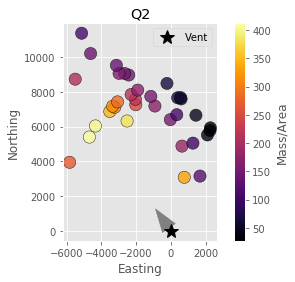

========Q2========
(-1, 1)
{'a': 2, 'b': 5, 'h1': 24000.0, 'u': -5.7357643635104605, 'v': 8.191520442889917, 'D': 4016.0, 'ftt': 6458.0, 'M': 55000000000.0}
a* = -3.04662	b* = -0.11643	            h1* = 134.67548	u* = -5.21641	v* = 7.49243	            D* = 8.15897	ftt* = 8.77307	TM* = 24.73060
a = 1.04752	b = 1.89009	            h1 = 30000.00000	u = -5.21641	v = 7.49243	            D = 3494.57207	ftt = 6458.00000	TM = 55000000000.00002
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 776
SSE: 7.762670604200857


,Height,Suspended Mass
0,"4,430.75",4.80439e+09
1,"5,776.5",4.73198e+09
2,"7,122.25",4.58475e+09
3,"8,468",4.40369e+09
4,"9,813.75",4.20217e+09
5,"11,159.5",3.98627e+09
6,"12,505.2",3.75924e+09
7,"13,851",3.52302e+09
8,"15,196.8",3.27876e+09
9,"16,542.5",3.0272e+09


[]


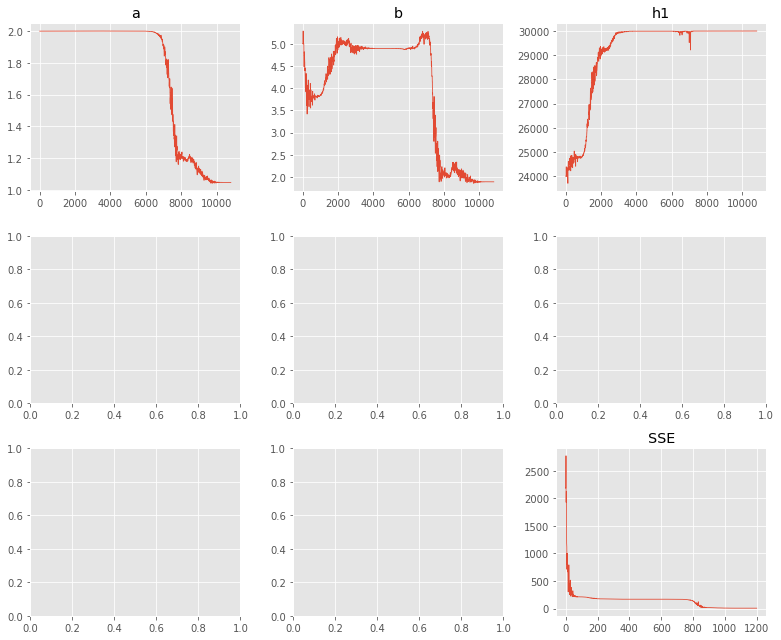

Q2 Run Time: 1.73568 minutes




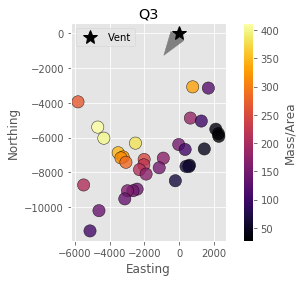

========Q3========
(-1, -1)
{'a': 2, 'b': 5, 'h1': 24000.0, 'u': -5.7357643635104605, 'v': -8.191520442889917, 'D': 4016.0, 'ftt': 6458.0, 'M': 55000000000.0}
a* = -3.04662	b* = -0.11643	            h1* = 134.67548	u* = -5.21641	v* = -7.49243	            D* = 8.15897	ftt* = 8.77307	TM* = 24.73060
a = 1.04752	b = 1.89009	            h1 = 30000.00000	u = -5.21641	v = -7.49243	            D = 3494.57207	ftt = 6458.00000	TM = 55000000000.00002
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 776
SSE: 7.762670604200857


,Height,Suspended Mass
0,"4,430.75",4.80439e+09
1,"5,776.5",4.73198e+09
2,"7,122.25",4.58475e+09
3,"8,468",4.40369e+09
4,"9,813.75",4.20217e+09
5,"11,159.5",3.98627e+09
6,"12,505.2",3.75924e+09
7,"13,851",3.52302e+09
8,"15,196.8",3.27876e+09
9,"16,542.5",3.0272e+09


[]


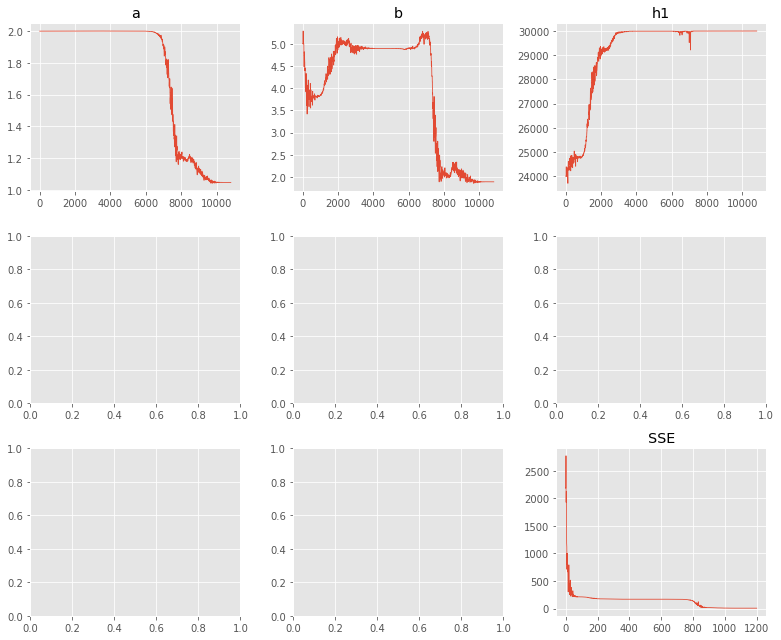

Q3 Run Time: 1.70339 minutes




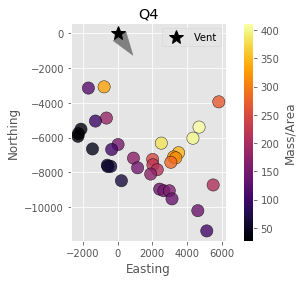

========Q4========
(1, -1)
{'a': 2, 'b': 5, 'h1': 24000.0, 'u': 5.7357643635104605, 'v': -8.191520442889917, 'D': 4016.0, 'ftt': 6458.0, 'M': 55000000000.0}
a* = -3.04662	b* = -0.11643	            h1* = 134.67548	u* = 5.21641	v* = -7.49243	            D* = 8.15897	ftt* = 8.77307	TM* = 24.73060
a = 1.04752	b = 1.89009	            h1 = 30000.00000	u = 5.21641	v = -7.49243	            D = 3494.57207	ftt = 6458.00000	TM = 55000000000.00002
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 776
SSE: 7.762670604200848


,Height,Suspended Mass
0,"4,430.75",4.80439e+09
1,"5,776.5",4.73198e+09
2,"7,122.25",4.58475e+09
3,"8,468",4.40369e+09
4,"9,813.75",4.20217e+09
5,"11,159.5",3.98627e+09
6,"12,505.2",3.75924e+09
7,"13,851",3.52302e+09
8,"15,196.8",3.27876e+09
9,"16,542.5",3.0272e+09


[]


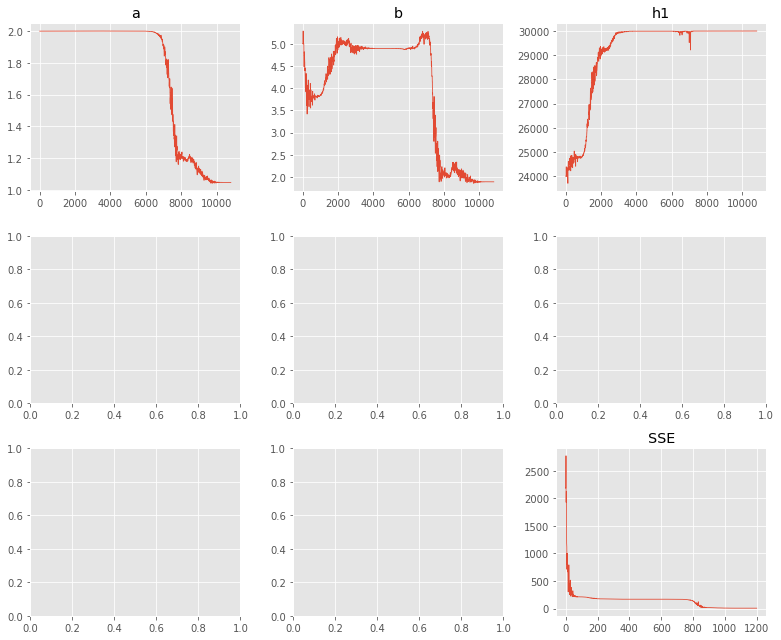

Q4 Run Time: 1.73255 minutes


Total Run Time: 6.90937 minutes


In [17]:
priors_vals = {
    "a": 2,
    "b": 5,
    "h1": config["PLUME_HEIGHT"],
    "u": u,
    "v": v,
    "D": config["DIFFUSION_COEFFICIENT"],
    "ftt": config["FALL_TIME_THRESHOLD"],
    "M": config["ERUPTION_MASS"]
}

invert_params = {
    "a" : True,
    "b" : True,
    "h1" : True,
    "u": True,
    "v": True,
    "D": True,
    "ftt": False,
    "M": False
}

H = 30000

t_tot = process_time()
single_run_time = 0
wind_angle = np.radians(55.5)

names = ["Q1", "Q2", "Q3", "Q4"]

inverted_masses_list = []
params_list = []
sim_params = {
    "a": config["ALPHA"],
    "b": config["BETA"],
    "h1": config["PLUME_HEIGHT"],
    "u": u,
    "v": v,
    "D": config["DIFFUSION_COEFFICIENT"],
    "ftt": config["FALL_TIME_THRESHOLD"],
    "M": config["ERUPTION_MASS"]
}
params_list += [sim_params]
for name, trans in zip(names, trans_tests):
    t = process_time()
    
    df = forward_df.copy()
    
    df["Easting"] = trans[0]*df["Easting"]
    df["Northing"] = trans[1]*df["Northing"]
    
    prior_vals_trans = priors_vals.copy()
    
    prior_vals_trans["u"] = trans[0]*prior_vals_trans["u"]
    prior_vals_trans["v"] = trans[1]*prior_vals_trans["v"]
    
    vis.plot_sample(df, vent=(0,0), log=False, title=name, cbar_label="Mass/Area",
                    wind=(prior_vals_trans["u"]*20,prior_vals_trans["v"]*20))
    plt.show()
    
    print("========%s========"%name)
    print(trans)
    print(prior_vals_trans)
    out = gaussian_stack_inversion(
        df, len(df), 20, config["VENT_ELEVATION"], 
        H, 2500, phi_steps,
        invert_params=invert_params,
        priors=prior_vals_trans,
        column_cap=H)
    inversion_table, params, sol, sse, plume_trace, param_trace, sse_trace = out
    inv_mass = inversion_table["Suspended Mass"].values
    inverted_masses_list += [inv_mass]
    params_list += [params]
    display(inversion_table)
    plume_trace = np.array(plume_trace)
    param_trace = np.array(param_trace)
    print(param_trace)
    fig, axs = plt.subplots(3,3, figsize=(
            11, 9), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    axs[0].plot(plume_trace[:,0], linewidth=.8)
    axs[0].set_title("a")

    axs[1].plot(plume_trace[:,1], linewidth=.8)
    axs[1].set_title("b")

    axs[2].plot(plume_trace[:,2], linewidth=.8)
    axs[2].set_title("h1")
    
#     axs[3].plot(param_trace[:,0], linewidth=.8)
#     axs[3].set_title("u")

#     axs[4].plot(param_trace[:,1], linewidth=.8)
#     axs[4].set_title("v")
    
#     axs[5].plot(param_trace[:,2], linewidth=.8)
#     axs[5].set_title("Diffusion Coefficient")
    
#     axs[6].plot(param_trace[:,3], linewidth=.8)
#     axs[6].set_title("Fall Time Threshold")
    
#     axs[7].plot(param_trace[:,4], linewidth=.8)
#     axs[7].set_title("Total Mass")

    axs[8].plot(sse_trace, linewidth=.8)
    axs[8].set_title("SSE")

    plt.tight_layout()
    # plt.savefig("colima/real_trace.png", dpi=200, format='png')
    plt.show()
    
    run_time = process_time() - t
    print("%s Run Time: %.5f minutes\n\n"%(name, run_time/60))


total_run_time = process_time() - t_tot

print("Total Run Time: %.5f minutes"%(total_run_time/60))

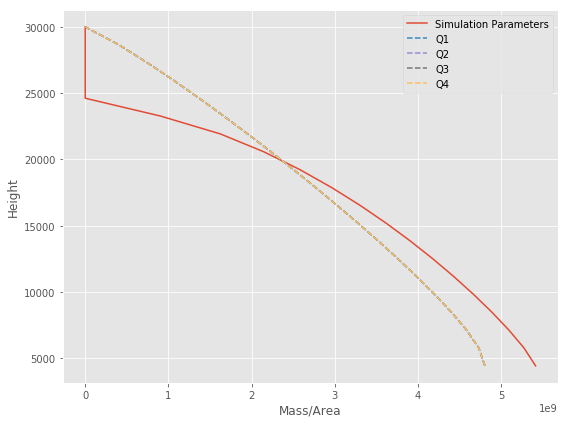

,Dataset,a,b,h1,u,v,D,ftt,M
0,Simulation Parameters,1.02,1.56,"24,000",5.73576,8.19152,"4,016","6,458",5.5e+10
1,Q1,1.04752,1.89009,"30,000",5.21641,7.49243,"3,494.57","6,458",5.5e+10
2,Q2,1.04752,1.89009,"30,000",-5.21641,7.49243,"3,494.57","6,458",5.5e+10
3,Q3,1.04752,1.89009,"30,000",-5.21641,-7.49243,"3,494.57","6,458",5.5e+10
4,Q4,1.04752,1.89009,"30,000",5.21641,-7.49243,"3,494.57","6,458",5.5e+10


In [18]:
fig, ax1 = plt.subplots(1,1, figsize=(
    8, 6), facecolor='w', edgecolor='k')

q_dist = beta(config["ALPHA"],config["BETA"])

q_mass = mass_dist_in_plume(config["ALPHA"],config["BETA"], config["VENT_ELEVATION"], 
            config["PLUME_HEIGHT"],
            inversion_table["Height"],
            config["ERUPTION_MASS"])

ax1.plot(q_mass, inversion_table["Height"], label="Simulation Parameters")
for name, mass in zip(names, inverted_masses_list):
    ax1.plot(mass, 
         inversion_table["Height"], 
         '--', label=name)
ax1.legend()
# ax1.set_title("Mass in Column as inverted from various datasets")
ax1.set_ylabel("Height")
ax1.set_xlabel("Mass/Area")

plt.tight_layout()
plt.show()
params_df = pd.DataFrame(params_list)
params_df["Dataset"] = ["Simulation Parameters"] + names
params_df = params_df[["Dataset", "a", "b", "h1", "u", "v", "D", "ftt", "M"]]
display(params_df)

========Q1========
{'a': 1.0475194152511638, 'b': 1.890094703060751, 'h1': 30000.0, 'u': 5.216410808335569, 'v': 7.4924318245442265, 'D': 3494.5720665051545, 'ftt': 6457.999999999996, 'M': 55000000000.00002}
(5.216410808335569, 7.4924318245442265)


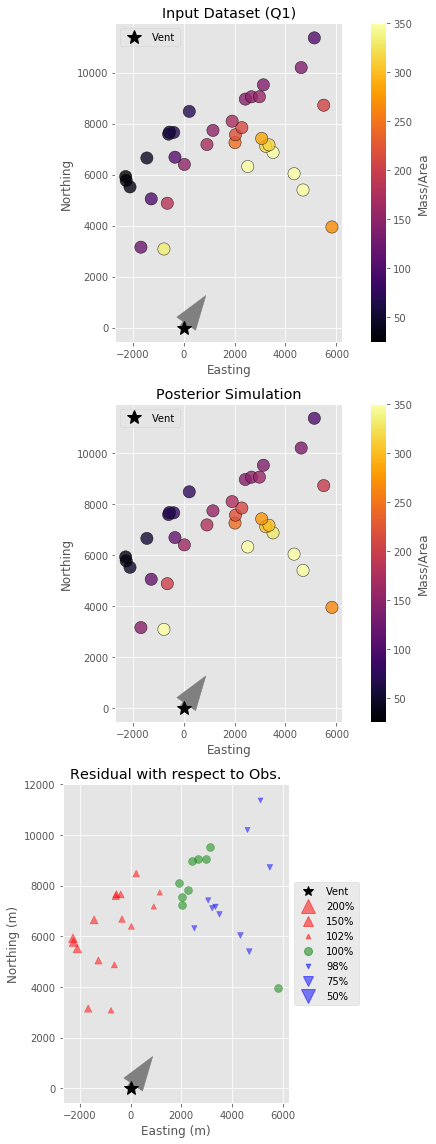

,Easting,Northing,MassArea,radius
0,-770,3082,354.081,"3,176.73"
1,-1673,3152,145.835,"3,568.48"
2,-637,4876,201.507,"4,917.43"
3,-1268,5048,117.391,"5,204.82"
4,-2101,5517,48.0781,"5,903.52"
5,-2250,5771,38.4673,"6,194.11"
6,-2272,5925,35.8124,"6,345.68"
7,32,6398,163.899,"6,398.08"
8,-337,6683,118.427,"6,691.49"
9,2519,6318,368.842,"6,801.65"


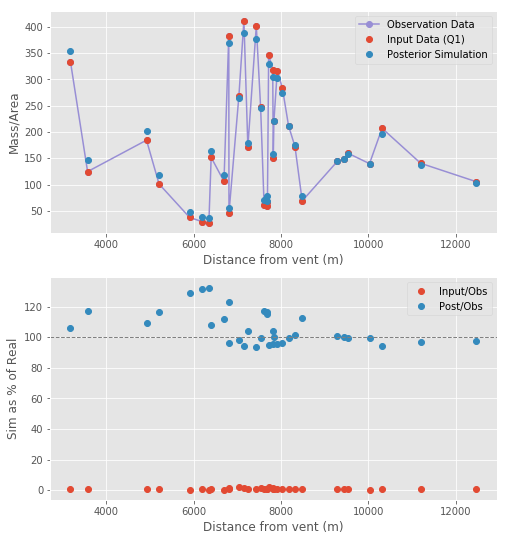

========Q2========
{'a': 1.0475194152511638, 'b': 1.890094703060751, 'h1': 30000.0, 'u': -5.216410808335569, 'v': 7.4924318245442265, 'D': 3494.5720665051545, 'ftt': 6457.999999999996, 'M': 55000000000.00002}
(-5.216410808335569, 7.4924318245442265)


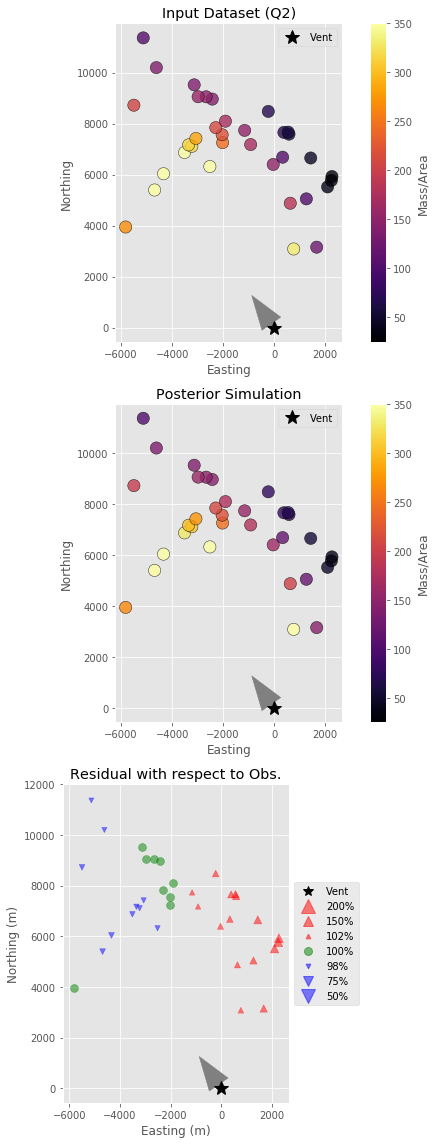

,Easting,Northing,MassArea,radius
0,770,3082,354.081,"3,176.73"
1,1673,3152,145.835,"3,568.48"
2,637,4876,201.507,"4,917.43"
3,1268,5048,117.391,"5,204.82"
4,2101,5517,48.0781,"5,903.52"
5,2250,5771,38.4673,"6,194.11"
6,2272,5925,35.8124,"6,345.68"
7,-32,6398,163.899,"6,398.08"
8,337,6683,118.427,"6,691.49"
9,-2519,6318,368.842,"6,801.65"


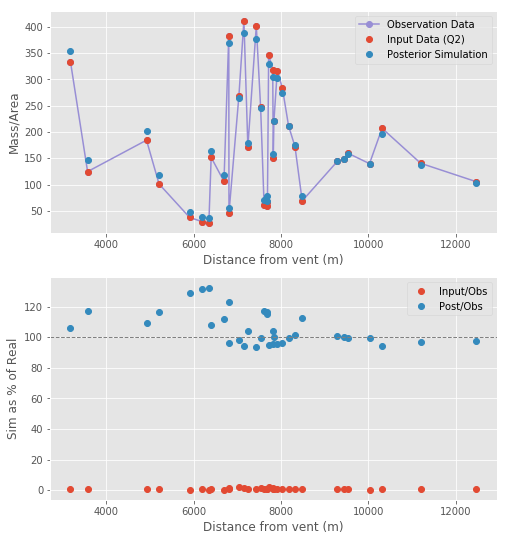

========Q3========
{'a': 1.0475194152511638, 'b': 1.890094703060751, 'h1': 30000.0, 'u': -5.216410808335569, 'v': -7.4924318245442265, 'D': 3494.5720665051545, 'ftt': 6457.999999999996, 'M': 55000000000.00002}
(-5.216410808335569, -7.4924318245442265)


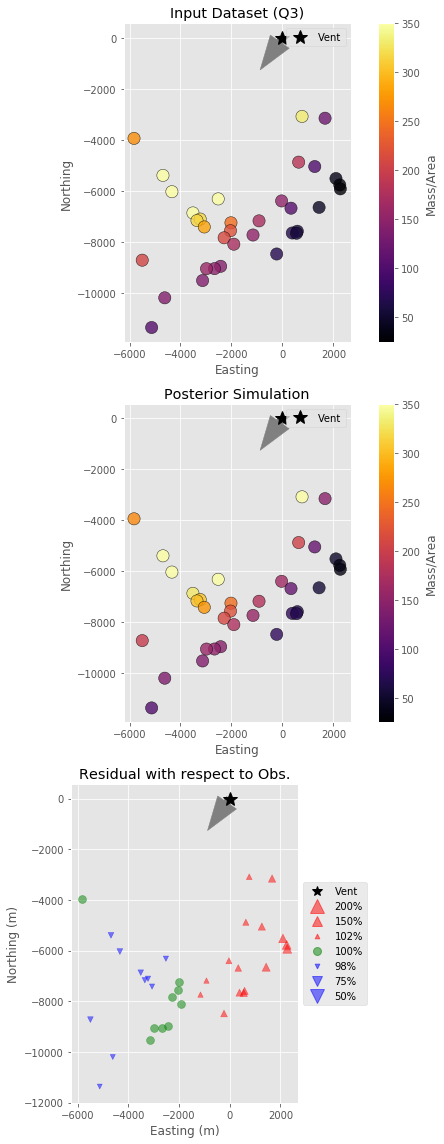

,Easting,Northing,MassArea,radius
0,770,-3082,354.081,"3,176.73"
1,1673,-3152,145.835,"3,568.48"
2,637,-4876,201.507,"4,917.43"
3,1268,-5048,117.391,"5,204.82"
4,2101,-5517,48.0781,"5,903.52"
5,2250,-5771,38.4673,"6,194.11"
6,2272,-5925,35.8124,"6,345.68"
7,-32,-6398,163.899,"6,398.08"
8,337,-6683,118.427,"6,691.49"
9,-2519,-6318,368.842,"6,801.65"


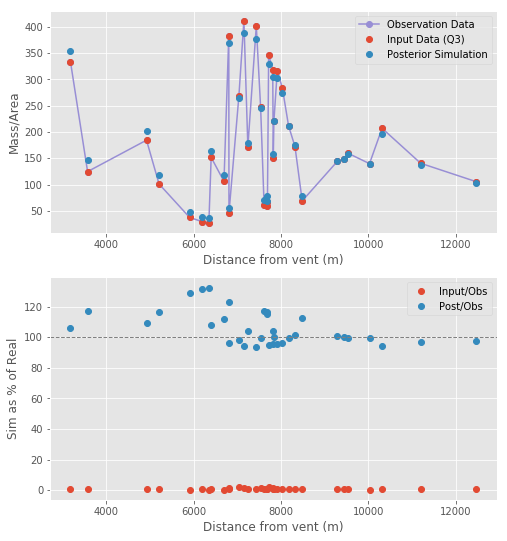

========Q4========
{'a': 1.0475194152511638, 'b': 1.890094703060751, 'h1': 30000.0, 'u': 5.216410808335569, 'v': -7.4924318245442265, 'D': 3494.5720665051545, 'ftt': 6457.999999999996, 'M': 55000000000.00002}
(5.216410808335569, -7.4924318245442265)


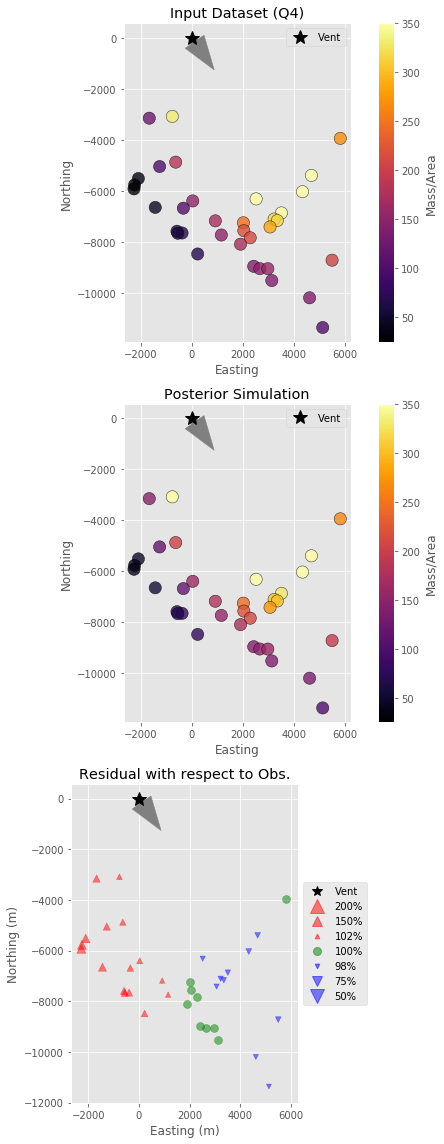

,Easting,Northing,MassArea,radius
0,-770,-3082,354.081,"3,176.73"
1,-1673,-3152,145.835,"3,568.48"
2,-637,-4876,201.507,"4,917.43"
3,-1268,-5048,117.391,"5,204.82"
4,-2101,-5517,48.0781,"5,903.52"
5,-2250,-5771,38.4673,"6,194.11"
6,-2272,-5925,35.8124,"6,345.68"
7,32,-6398,163.899,"6,398.08"
8,-337,-6683,118.427,"6,691.49"
9,2519,-6318,368.842,"6,801.65"


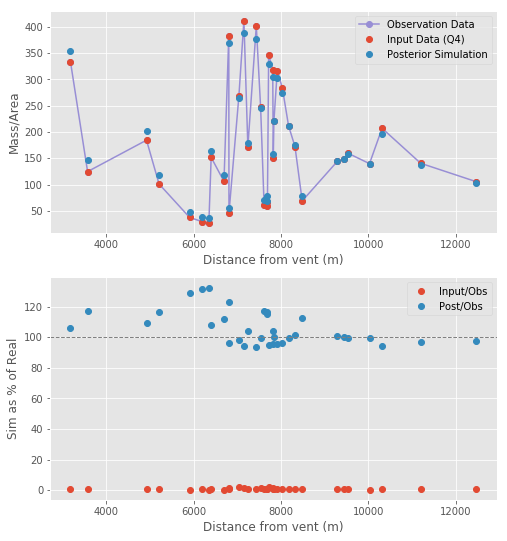

In [24]:



for name, params, mass, trans in zip(names, params_list[1:], inverted_masses_list, trans_tests):
    in_data = forward_df.copy()
    
    in_data["Easting"] = trans[0]*in_data["Easting"]
    in_data["Northing"] = trans[1]*in_data["Northing"]
    
    print("========%s========"%name)
    print(params)
    q_dist = beta(params["a"],params["b"])

    grid = in_data[["Easting", "Northing"]]
    
    print((params["u"],params["v"]))
    
    post_df = gaussian_stack_forward(
        grid, int(config["COL_STEPS"]), config["VENT_ELEVATION"], 
        params["h1"], 2500, phi_steps, (params["a"],params["b"]), config["ERUPTION_MASS"], 
        (params["u"],params["v"]), config["DIFFUSION_COEFFICIENT"], config["EDDY_CONST"],
        config["FALL_TIME_THRESHOLD"]
    )
    
    post_df["radius"] = np.sqrt(post_df["Easting"]**2 + post_df["Northing"]**2)
    post_df = post_df.sort_values(by=['radius'])
    post_df["Residual"] = post_df["MassArea"].values/in_data["MassArea"].values
    post_df["Change"] = post_df["MassArea"].values/in_data["MassArea"].values/100
    
    fig, axs = plt.subplots(3,1, figsize=(
            8, 16), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    bounds = (25, 350)
    vis.plot_sample(in_data, vent=(0,0), log=False,bounds=bounds, 
                title="Input Dataset (%s)"%name, cbar_label="Mass/Area", ax=axs[0],
                wind=(params["u"]*20,params["v"]*20))
    vis.plot_sample(post_df, vent=(0,0), log=False, bounds=bounds,
                title="Posterior Simulation", cbar_label="Mass/Area", ax=axs[1],
                wind=(params["u"]*20,params["v"]*20))
#     vis.plot_residuals(post_df, vent=(0,0), values="Change", plot_type="size",
#                 title="Change from Input Dataset", ax=axs[2])
    vis.plot_residuals(post_df, vent=(0,0), values="Residual", plot_type="size",
                title="Residual with respect to Obs.", ax=axs[2],
                wind=(params["u"]*20,params["v"]*20))

    plt.tight_layout()
    plt.show()
    
    
    display(post_df[["Easting", "Northing", "MassArea", "radius"]])
    
    
    fig, axs = plt.subplots(2,1, figsize=(
            8, 9), facecolor='w', edgecolor='k')
    axs = axs.ravel()

    axs[0].plot(obs_df["radius"].values, in_data["MassArea"].values, 'C2o-', label="Observation Data")
    axs[0].plot(in_data["radius"].values, in_data["MassArea"].values, 'C0o', label="Input Data (%s)"%name)
    axs[0].plot(post_df["radius"].values, post_df["MassArea"].values, 'C1o', label="Posterior Simulation")
    axs[0].legend()
    axs[0].set_xlabel("Distance from vent (m)")
    axs[0].set_ylabel("Mass/Area")


    axs[1].plot(in_data["radius"].values, in_data["Residual"].values, 'C0o', label="Input/Obs")
    axs[1].plot(post_df["radius"].values, post_df["Residual"].values*100, 'C1o', label="Post/Obs")
    axs[1].axhline(100, linestyle="--", lw=1, c="gray")
    axs[1].legend()
    axs[1].set_xlabel("Distance from vent (m)")
    axs[1].set_ylabel("Sim as % of Real")
    plt.show()
    
   

In [22]:
display(df_all_qs[names])

plt.plot(df_all_qs[names])
plt.show()

NameError: name 'df_all_qs' is not defined

In [4]:
from scipy.special import betainc

[ 4000.          5368.42105263  6736.84210526  8105.26315789
  9473.68421053 10842.10526316 12210.52631579 13578.94736842
 14947.36842105 16315.78947368 17684.21052632 19052.63157895
 20421.05263158 21789.47368421 23157.89473684 24526.31578947
 25894.73684211 27263.15789474 28631.57894737 30000.        ]
[ 3999.86666667  5368.2877193   6736.70877193  8105.12982456
  9473.55087719 10841.97192982 12210.39298246 13578.81403509
 14947.23508772 16315.65614035 17684.07719298 19052.49824561
 20420.91929825 21789.34035088 23157.76140351 24526.18245614
 25894.60350877 27263.0245614  28631.44561404 29999.86666667]
[0.         0.0664356  0.13292852 0.19825847 0.2621155  0.32432114
 0.38474411 0.44327376 0.49980848 0.55424939 0.60649618 0.65644378
 0.70397923 0.74897828 0.79130113 0.83078694 0.86724572 0.90044607
 0.9300947  0.95579867]


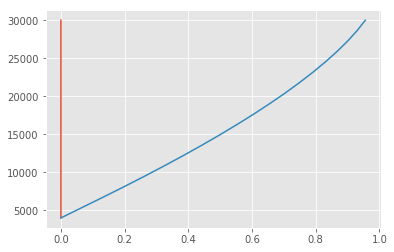

In [21]:
x = np.linspace(4000,30000,20)
x2 = (x-4000/30000)
print(x)
print(x2)
a = 1.02 
b = 1.56
f1 = beta.pdf(x=x, a=a, b=b, loc=4000, scale=(24000-4000))
f2 = betainc(a, b, (x-4000)/30000)
print(f2)
plt.plot(f1, x)
plt.plot(f2, x)
plt.show()